## Importing Dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username": "namanshah01",
         "key": "c5ba2132962d721dfc0e9d550f916c33"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!touch /content/.kaggle/kaggle.json

In [ ]:
# verifying contents of the file
f = open("/content/.kaggle/kaggle.json", "r")
print(f.read())
f.close()

{"username": "namanshah01", "key": "c5ba2132962d721dfc0e9d550f916c33"}


In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# downloading the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:11<00:00, 59.4MB/s]
100% 2.29G/2.29G [01:11<00:00, 34.4MB/s]


In [ ]:
# unziping the dataset
!unzip /content/{/content}/datasets/paultimothymooney/chest-xray-pneumonia/chest-xray-pneumonia.zip

## Structuring The Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import cv2
import os
import random

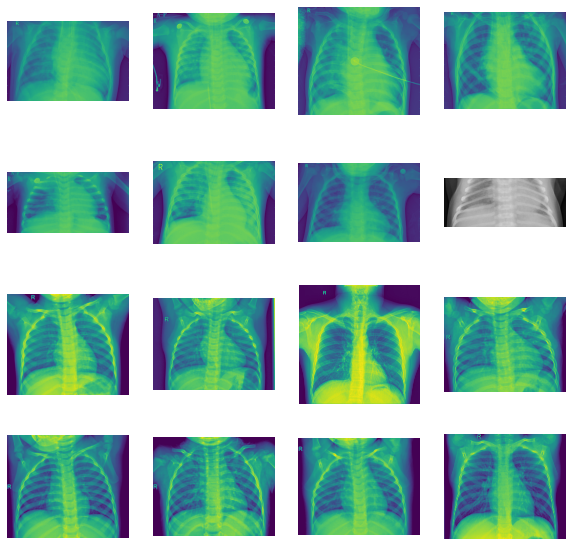

In [ ]:
# having a look at given data
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# output images in a 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 2.5, nrows * 2.5)

pnu_pics = [os.path.join('/content/chest_xray/train/PNEUMONIA', fname) for fname in os.listdir('/content/chest_xray/train/PNEUMONIA')[:8]]
nor_pics = [os.path.join('/content/chest_xray/train/NORMAL', fname) for fname in os.listdir('/content/chest_xray/train/NORMAL')[:8]]

for i, img_path in enumerate(pnu_pics + nor_pics):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

# top 8 pneumonic x-rays, bottom 8 normal x-rays
plt.show()

In [ ]:
# function to resize images (rescale to 150 x 150),
# grayscale images (remove 3 rgb layers and convert to single grayscale layer)
# colours aren't essential to analyze x-rays, grayscaling them would help model train better,
# and reduce the data to be processed by a significant amount

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test  = get_training_data('/content/chest_xray/test')
val   = get_training_data('/content/chest_xray/val')

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# normalizing inputs
x_train = np.array(x_train) / 255
x_test  = np.array(x_test) / 255
x_val   = np.array(x_val) / 255

In [ ]:
# resizing data in variables
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# checking amount of data availible
print('Train set images:', len(x_train))
print('Validation set images:', len(x_val))
print('Test set images:', len(x_test))

Train set images: 5216
Validation set images: 16
Test set images: 624


## Training Model

In [ ]:
# using data augmentation to reduce variance
datagen = ImageDataGenerator(
        rotation_range = 30,    # rotate images in the range 30 degrees
        zoom_range = 0.2,       # zoom image 
        width_shift_range=0.1,  # shift images horizontally (fraction of total width)
        height_shift_range=0.1, # shift images vertically (fraction of total height)
        horizontal_flip = True, # flip images
        )

In [ ]:
# stopping training if
#   accuracy reaches 94%
#   no significant change in accuracy per epoch

class myCallback(tf.keras.callbacks.Callback):
    prev_acc = None
    count = 0
    def on_epoch_end(self, epoch, logs={}):
        try:
            if ((logs.get('accuracy') - myCallback.prev_acc) < 0.0025):
                myCallback.count += 1
        except:
            pass
        myCallback.prev_acc = logs.get('accuracy')
        if(myCallback.count > 1):
            print('Accuracy is flattening out, no significant changes being observed')
            self.model.stop_training = True
        if(logs.get('accuracy')>0.94):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# creating the model
model = tf.keras.models.Sequential([
        # convolution 1
        tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(150,150,1), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        # convolution 2
        tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        # convolution 3
        tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        # flattening
        tf.keras.layers.Flatten(),
        # dense layer 1
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        # dense layer 2
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.25),
        # output neuron
        tf.keras.layers.Dense(1, activation="sigmoid")
])

# details of the CNN
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        1

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# training the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size = 32),
    epochs = 15,
    validation_data = datagen.flow(x_val, y_val),
    callbacks = [callbacks]
    )

Epoch 1/15
163/163 [==============================] - 9s 58ms/step - loss: 0.8203 - accuracy: 0.8006 - val_loss: 19.9543 - val_accuracy: 0.5000
Epoch 2/15
163/163 [==============================] - 9s 57ms/step - loss: 0.3838 - accuracy: 0.8574 - val_loss: 15.4052 - val_accuracy: 0.5000
Epoch 3/15
163/163 [==============================] - 9s 58ms/step - loss: 0.2928 - accuracy: 0.8790 - val_loss: 28.0906 - val_accuracy: 0.5000
Epoch 4/15
163/163 [==============================] - 10s 59ms/step - loss: 0.2611 - accuracy: 0.9009 - val_loss: 7.8588 - val_accuracy: 0.5000
Epoch 5/15
163/163 [==============================] - 9s 58ms/step - loss: 0.2390 - accuracy: 0.9076 - val_loss: 0.7087 - val_accuracy: 0.5625
Epoch 6/15
163/163 [==============================] - 9s 58ms/step - loss: 0.2115 - accuracy: 0.9195 - val_loss: 11.2544 - val_accuracy: 0.5000
Epoch 7/15
163/163 [==============================] - 9s 57ms/step - loss: 0.2345 - accuracy: 0.9168 - val_loss: 1.7446 - val_accuracy: 0

In [ ]:
print(f"Loss : {model.evaluate(x_test,y_test)[0]}")
print(f"Accuracy % : {model.evaluate(x_test,y_test)[1]*100}")

20/20 [==============================] - 0s 7ms/step - loss: 0.2998 - accuracy: 0.9006
Loss : 0.29984134435653687
20/20 [==============================] - 0s 7ms/step - loss: 0.2998 - accuracy: 0.9006
Accuracy % : 90.06410241127014


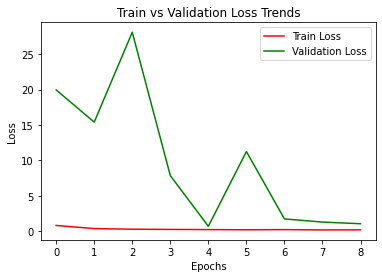

In [ ]:
# train and validation loss trends
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [i for i in range(0, 9)]
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Train vs Validation Loss Trends')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

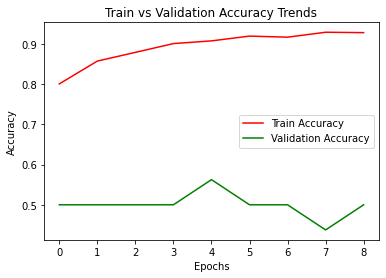

In [ ]:
# train and validation Accuracy trends
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = [i for i in range(0, 9)]
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy Trends')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Results of the model

### On Test Set

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, predictions), sep='')
print(f'Accuracy Score: {accuracy_score(y_test, predictions)*100}%')

Confusion Matrix:
[[379  11]
 [ 51 183]]
Accuracy Score: 90.06410256410257%


In [ ]:
# detailed stats on models performance
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.97      0.92       390
   Normal (Class 1)       0.94      0.78      0.86       234

           accuracy                           0.90       624
          macro avg       0.91      0.88      0.89       624
       weighted avg       0.90      0.90      0.90       624



### On Train Set

In [ ]:
pred_train = model.predict_classes(x_train)
pred_train = pred_train.reshape(1,-1)[0]

# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_train, pred_train), sep='')
print(f'Accuracy Score: {accuracy_score(y_train, pred_train)*100}%')

Confusion Matrix:
[[3523  352]
 [  42 1299]]
Accuracy Score: 92.4463190184049%


In [ ]:
print(classification_report(y_train, pred_train, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.91      0.95      3875
   Normal (Class 1)       0.79      0.97      0.87      1341

           accuracy                           0.92      5216
          macro avg       0.89      0.94      0.91      5216
       weighted avg       0.94      0.92      0.93      5216



### Visual Representation of Features Learnt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


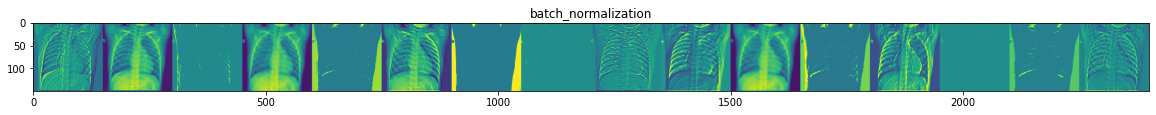

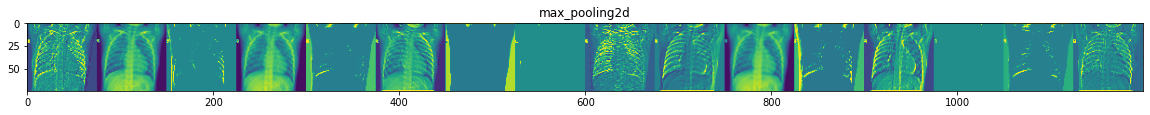

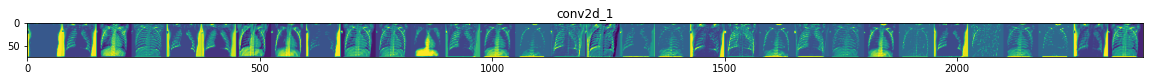

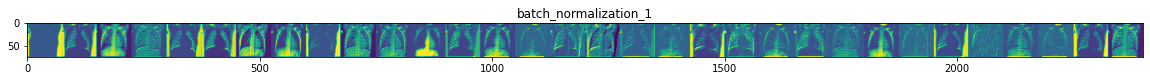

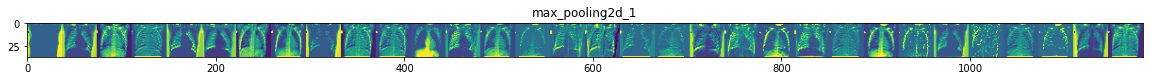

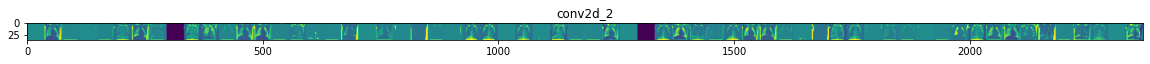

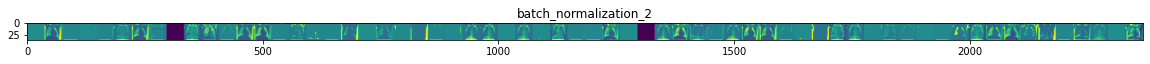

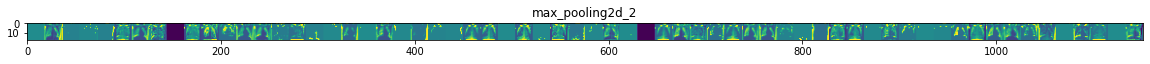

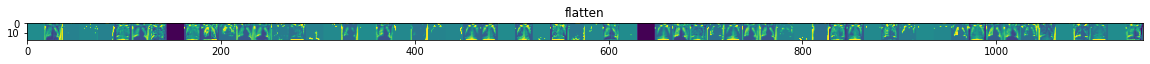

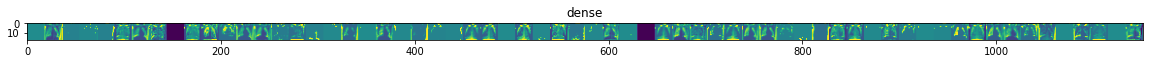

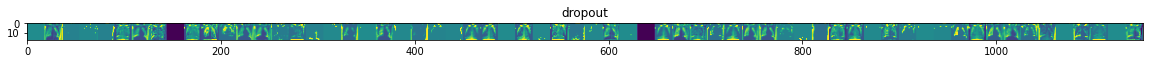

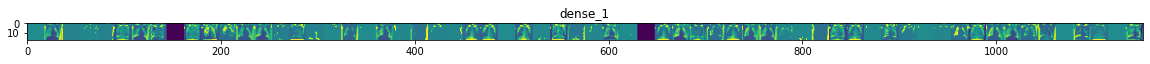

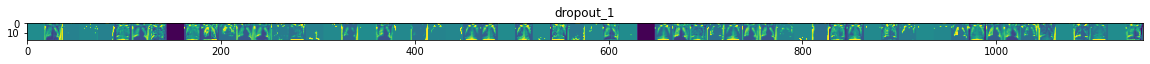

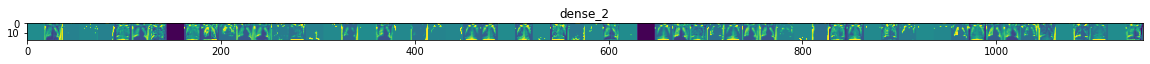

In [ ]:
# below is a representaion of the processing of the image from each filter after every layer as percieved by the model
# presence or absence those highlighted features play a key role in determining the output(prediction)

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

nor_img_files = [os.path.join('/content/chest_xray/train/NORMAL', f) for f in os.listdir('/content/chest_xray/train/NORMAL')]
pnu_img_files = [os.path.join('/content/chest_xray/train/PNEUMONIA', f) for f in os.listdir('/content/chest_xray/train/PNEUMONIA')]

# randomly choosing an image
img_path = random.choice(pnu_img_files + nor_img_files)

# processing image
img_arr = cv2.imread(os.path.join(img_path), cv2.IMREAD_GRAYSCALE)
resized_arr = cv2.resize(img_arr, (150, 150))
resized_arr = np.array(resized_arr)/255
resized_arr = resized_arr.reshape(-1, 150, 150, 1)

# obtaining intermediate representations the image
successive_feature_maps = visualization_model.predict(resized_arr)

# obtaining names of layers to go with the layers
layer_names = [layer.name for layer in model.layers[1:]]

# displaying the representaions
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        # tiling images in a matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocessing feature to make more perceivable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # tiling each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
    # displaying the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Predicting On Other Images

In [ ]:
!mkdir /content/check_im

In [ ]:
# upload files in the check_im direcotry
# run on 1 file at a time to prevent shuffling of image names and their readings

In [ ]:
img_size = 150
def get_check_im(check_im_dir):
    data = []
    images = []
    for img in os.listdir(check_im_dir):
        images.append(img)
        try:
            img_arr = cv2.imread(os.path.join(check_im_dir, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(resized_arr)
        except Exception as e:
            pass
    return np.array(data), images

In [ ]:
check_im, img_name = get_check_im('/content/check_im')

check_im_test = []
for feature in check_im:
    check_im_test.append(feature)

check_im_test = np.array(check_im_test) / 255
check_im_test = check_im_test.reshape(-1, img_size, img_size, 1)

pred = model.predict(check_im_test)
pred = pred.reshape(1,-1)[0]

for i in range(0, len(pred)):
    if pred[i] > 0.5:
        print(f'{img_name[i]}\t-\t{pred[i]}\t-\tNormal')
    else:
        print(f'{img_name[i]}\t-\t{pred[i]}\t-\tPneumonia')

IM-0005-0001.jpeg	-	0.7518223524093628	-	Normal
.ipynb_checkpoints	-	0.2905172109603882	-	Pneumonia
person100_bacteria_475.jpeg	-	0.006870401557534933	-	Pneumonia
person100_bacteria_478.jpeg	-	0.8051222562789917	-	Normal
IM-0003-0001.jpeg	-	0.7596801519393921	-	Normal
IM-0001-0001.jpeg	-	0.23909085988998413	-	Pneumonia


## Saving The Model

In [ ]:
# saving the model (with .h5 and .json file)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

model.save('my_model.h5')